# Chapter 7: Moving Beyond Linearity
- **Chapter 7 from the book [An Introduction to Statistical Learning](https://www.statlearning.com/)**
- **By Gareth James, Daniela Witten, Trevor Hastie and Rob Tibshirani**
- **Pages from $299$ to $301$**
- **By [$\text{Mosta Ashour}$](https://www.linkedin.com/in/mosta-ashour/)**


**Exercises:**
- **[6.](#6) [(a)](#6a) [(b)](#6b)**
- **[7.](#7)**
- **[8.](#8)**
- **[9.](#9) [(a)](#9a) [(b)](#9b) [(c)](#9c) [(d)](#9d) [(e)](#9e) [(f)](#9f)**
- **[10.](#10) [(a)](#10a) [(b)](#10b) [(c)](#10c) [(d)](#10d)**
- **[11.](#11) [(a)](#11a) [(b)](#11b) [(c)](#11c) [(d)](#11d) [(e)](#11e) [(f)](#11f) [(g)](#11g)**
- **[12.](#12)**

# <span style="font-family:cursive;color:#0071bb;"> 7.9 Exercises </span>
## <span style="font-family:cursive;color:#0071bb;"> Applied </span>

In [1]:
import numpy as np
import pandas as pd
import patsy as pt
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.ch6 import *
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from pygam import LinearGAM, s, f, l

from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

<a id='6'></a>
### $6.$ In this exercise, you will further analyze the $\color{red}{\text{Wage}}$ data set considered throughout this chapter.

<a id='6a'></a>
**$(a)$ Perform polynomial regression to predict $\color{red}{\text{Wage}}$ using $\color{red}{\text{age}}$. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using $\text{ANOVA}$? Make a plot of the resulting polynomial fit to the data.**

In [2]:
wage_df = pd.read_csv('datasets/Wage.csv').drop('Unnamed: 0', axis=1)
wage_df.head(3)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


### Cross val

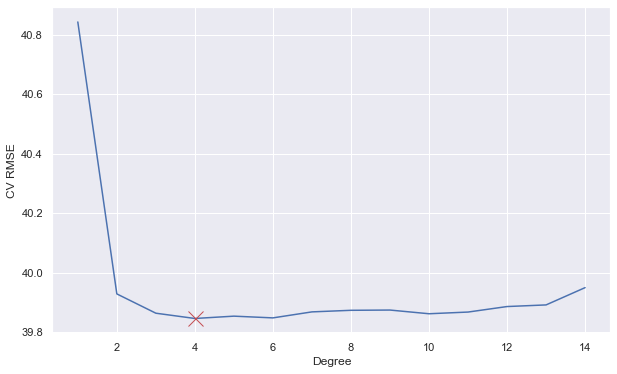

Min RMSE : 39.84520702119436
Degree   : 4


In [3]:
def best_polynomial_degree(x, y, df, n_degrees=15):
    # Perform CV for increasing polynomial order
    results = [] 
    y = np.asarray(df[y])
    for d in np.arange(1,n_degrees):
        f = ' + '.join([f'np.power({x}, {i})' for i in np.arange(1, d+1)])
        X = pt.dmatrix(f, df)
        
        # fit model
        lr = LinearRegression(fit_intercept=True)
        scores = cross_val_score(lr, X, y, cv=10, scoring='neg_root_mean_squared_error')
        results.append([np.mean(np.abs(scores)), d])

    # Plot the results
    df = pd.DataFrame({'CV RMSE': [r[0] for r in results],
                       'Degree': [r[1] for r in results]})   
    min_rsme = min(results)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x='Degree', y='CV RMSE', data=df)
    plt.plot(min_rsme[1], min_rsme[0], 'rx', ms=15)
    plt.show();

    # Choose model
    print('Min RMSE : {}'.format(min(results)[0]))
    print('Degree   : {}'.format(min(results)[1]))

best_polynomial_degree('age', 'wage', wage_df)

### ANOVA

In [4]:
# Derive 5 degree polynomial features of age
degree = 5
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = pt.dmatrix(f, wage_df)
y = np.asarray(wage_df['wage'])

# Get models of increasing degrees
model_1 = sm.OLS(y, X[:, 0:2]).fit()
model_2 = sm.OLS(y, X[:, 0:3]).fit()
model_3 = sm.OLS(y, X[:, 0:4]).fit()
model_4 = sm.OLS(y, X[:, 0:5]).fit()
model_5 = sm.OLS(y, X[:, 0:6]).fit()

# Compare models with ANOVA
res = sm.stats.anova_lm(model_1, model_2, model_3, model_4, model_5)
res.index = range(1,6)
display(res)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
2,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
3,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
4,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
5,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


>- Cross validation chooses a $4$th degree polynomial model which provides the lowest $\text{RSME}$.
>- But $\text{ANOVA}$ selects the $3$rd degree model which scores only slightly below optimal in cross validation. 

>- Now, let's plot the $3$rd vs $4$th polynomials fit: 

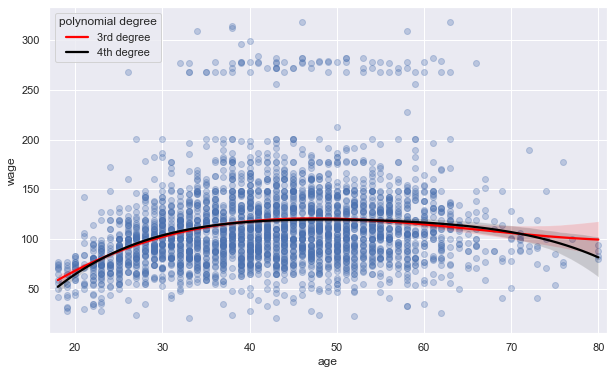

In [5]:
plt.figure(figsize=(10,6))
ax = sns.regplot(x="age", y="wage", data=wage_df,
                 scatter_kws={'alpha':0.3}, line_kws={"color": "red"}, order=3)

ax = sns.regplot(x="age", y="wage", data=wage_df,
                 scatter=False, line_kws={"color": "black"}, order=4)
ax.set(xlim=(17, 81));
ax.legend(title='polynomial degree', loc='upper left', labels=['3rd degree', '4th degree']);

<a id='6b'></a>
**$(b)$ Fit a step function to predict $\color{red}{\text{Wage}}$ using age, and perform cross validation to choose the optimal number of cuts. Make a plot of the fit obtained.**

In [6]:
def step_function(X1, y1, n_cuts=30):
    # CHOOSE BEST MODEL
    # ----------------------------------
    
    results = [] 
    for steps in np.arange(2, n_cuts):
        # Segment data into 4 segments by age
        cuts = pd.cut(X1, steps)
        X = np.asarray(pd.get_dummies(cuts))
        y = np.asarray(y1)

        # fit model
        lr = LinearRegression(fit_intercept=True)
        scores = cross_val_score(lr, X, y, cv=10, scoring='neg_root_mean_squared_error')
        results.append([np.mean(np.abs(scores)), steps])

    # Plot the results
    df = pd.DataFrame({'RMSE': [r[0] for r in results],
                       'steps': [r[1] for r in results]})  

    plt.figure(figsize=(10,6))
    ax = sns.lineplot(x='steps', y='RMSE', data=df, color='b')
    plt.plot(min(results)[1], min(results)[0], 'rx', ms=15)
    plt.show();

    # Choose model
    print('Min RMSE : {}'.format(min(results)[0]))
    print('Steps   : {}'.format(min(results)[1]))
    
    # PLOT BEST MODEL
    # ----------------------------------
    steps = min(results)[1]

    # Segment data into 4 segments by age
    cuts = pd.cut(X1, steps)
    X = np.asarray(pd.get_dummies(cuts))
    y = np.asarray(y1).reshape(-1, 1)

    # Fit logistic regression model
    model = LinearRegression(fit_intercept=True).fit(X, y)
    y_hat = model.predict(X)

    # Plot datapoints
    plt.figure(figsize=(10,6))
    ax = sns.scatterplot(x=X1.name, y=y1.name,
                         alpha=0.3,
                         data=pd.concat([X1, y1], axis=1));

    # Plot estimated f(x)
    sns.lineplot(x=X1, y=y_hat.reshape(-1), ax=ax, color='black')
    plt.show();

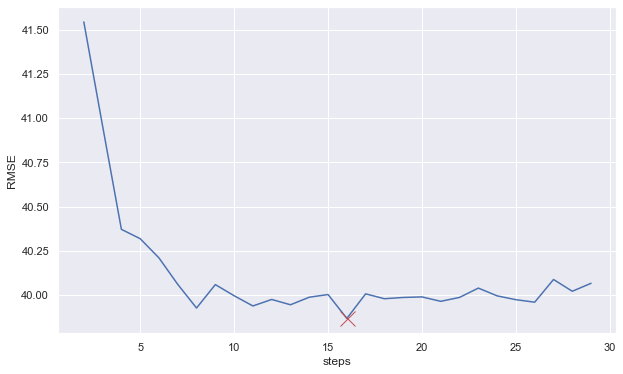

Min RMSE : 39.86787070745167
Steps   : 16


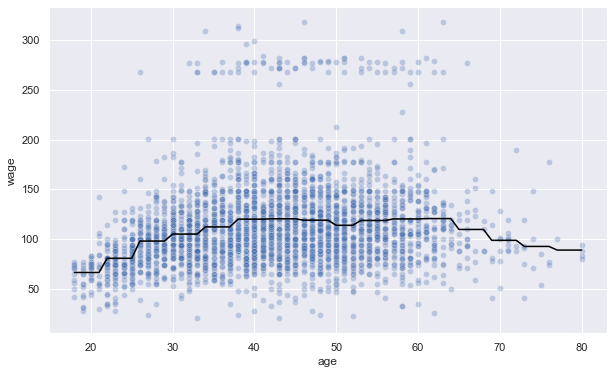

In [7]:
step_function(wage_df.age, wage_df.wage, n_cuts=30)

<a id='7'></a>
### $7.$ The $\color{red}{\text{Wage}}$ data set contains a number of other features not explored in this chapter, such as marital status ($\color{red}{\text{maritl}}$), job class ($\color{red}{\text{jobclass}}$), and others. Explore the relationships between some of these other predictors and $\color{red}{\text{Wage}}$, and use non-linear fitting techniques in order to fit flexible models to the data. Create plots of the results obtained, and write a summary of your findings.

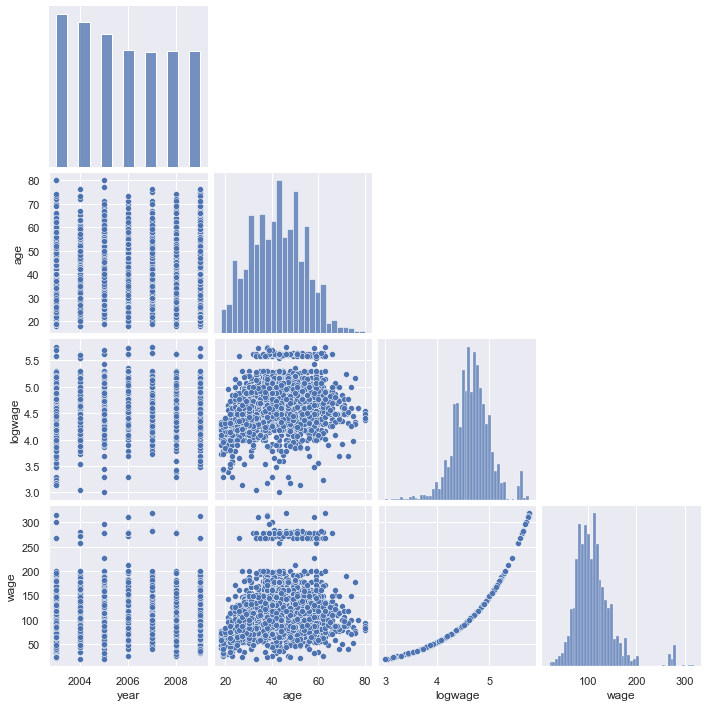

In [8]:
sns.pairplot(data=wage_df, corner=True);

In [9]:
sorted(wage_df['education'].unique())

['1. < HS Grad',
 '2. HS Grad',
 '3. Some College',
 '4. College Grad',
 '5. Advanced Degree']

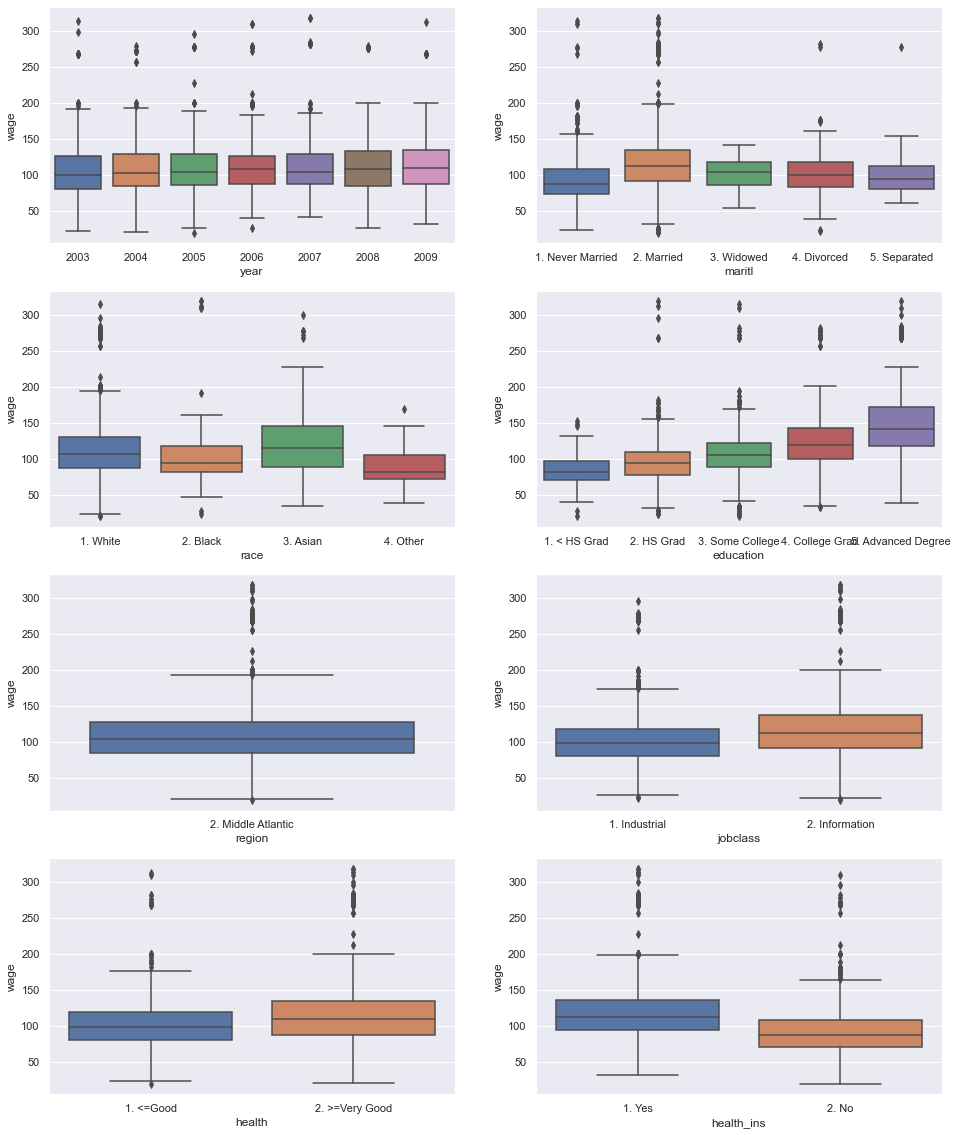

In [10]:
categoricals = wage_df.drop(['age', 'logwage', 'wage'], axis=1).columns

fig, axes = plt.subplots(4, 2, figsize=(16,20))
for i in range(int(len(categoricals)/2)):
    c1 = categoricals[i*2]
    c2 = categoricals[i*2 + 1]
    sns.boxplot(x=c1, y='wage', data=wage_df, ax=axes[i, 0], order=sorted(wage_df[c1].unique()))
    sns.boxplot(x=c2, y='wage', data=wage_df, ax=axes[i, 1], order=sorted(wage_df[c2].unique()))

In [11]:
wage_df.race.value_counts()

1. White    2480
2. Black     293
3. Asian     190
4. Other      37
Name: race, dtype: int64

>**Comments:**
>- **`year`:** The variable `year` is a numeric variable, still it's a categorical variable, thus we can't use splines to describe the relationship. The box plot shows that there's no a relationship between `year` and `wage`.
>- **`maritl`**: It appears that Married individuals gain earnings comparing to others.
>- **`race`**: In this dataset Asian tend to earn more. Still the values are not fair to compare with ("Which the data contains 2480 White, 190 Asian").
>- **`education`**: This is an ordinal categorical variable. We can see a positive relationship between `education` and `year`. And we know from lab that its best model is linear.
>- **`region`**: It only has one unique value so should be ignored.
>- **`jobclass`**: The job class seams to have a lightly effect on their wages .
>- **`health` and `health_ins`**: They look slightly similar. But we can see that workers with health insurance are on average higher paid.
>- **`age`**: we know from above that 4 degree polynomial model well perform the best.
>- **`logwage`**: It is just log of wage so we won't use it.

**Now, let's see an example on why we shouldn't use splines on a categorical variables.
Let's use the variable `education` in this example.**

In [12]:
# Treat education as ordinal
education = wage_df['education'].map({'1. < HS Grad': 1.0, 
                                      '2. HS Grad': 2.0, 
                                      '3. Some College': 3.0,
                                      '4. College Grad': 4.0,
                                      '5. Advanced Degree': 5.0})

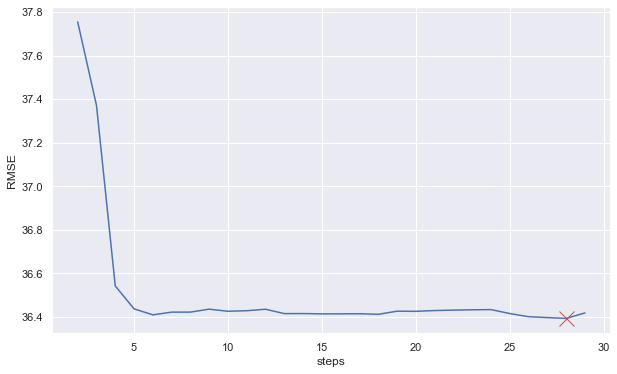

Min RMSE : 36.39314221717892
Steps   : 28


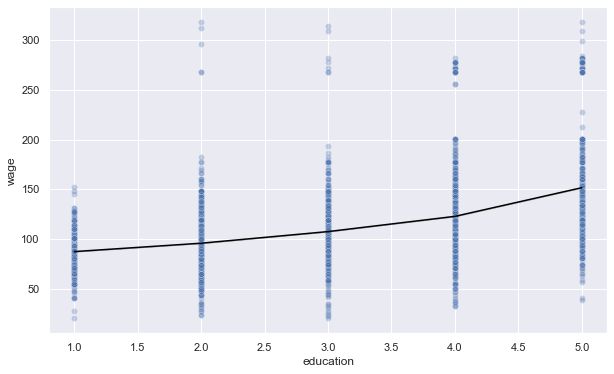

In [13]:
step_function(education, wage_df.wage, n_cuts=30)

>- As we can see the best model with the minimum RMSE have 5 steps, which are the exact 5 values on the variable `education`.

**Now let's fit a linear regression model with the 4th degree polynomial for `age` with the other variables discussed above using Naive backward stepwise selection.**

Min RMSE            : 33.80172350304156
Best predictor count: 19


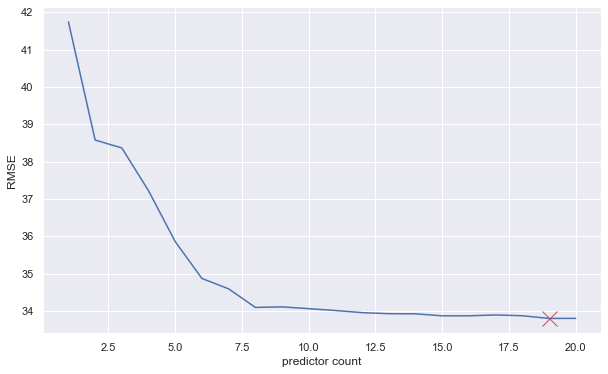

,predictor,selected
0,Intercept,True
1,C(education)[T.2. HS Grad],True
2,C(education)[T.3. Some College],True
3,C(education)[T.4. College Grad],True
4,C(education)[T.5. Advanced Degree],True
5,C(maritl)[T.2. Married],True
6,C(maritl)[T.3. Widowed],True
7,C(maritl)[T.4. Divorced],False
8,C(maritl)[T.5. Separated],True
9,C(race)[T.2. Black],True


In [14]:
# Create features
f = 'cr(age, df=4) + year + C(education) + C(maritl) + C(race) + C(jobclass) + C(health) + C(health_ins)'
X = pt.dmatrix(f , wage_df)
y = np.asarray(wage_df['wage'])

# Backward stepwise feature selection
lr = LinearRegression(fit_intercept=False)
model = RFECV(lr, step=1, cv=10, scoring='neg_mean_squared_error')
model = model.fit(X, y)

# Best model stats
RMSEs_backward  = np.sqrt(np.abs(model.grid_scores_))
predictor_count = np.arange(1, 1+len(RMSEs_backward))
df = pd.DataFrame({'RMSE': RMSEs_backward, 'predictor count': predictor_count})
print('Min RMSE            : {}'.format(min(RMSEs_backward)))
print('Best predictor count: {}'.format(np.sum(model.support_)))

# Plot RMSE for each step
plt.figure(figsize=(10, 6))
sns.lineplot(x='predictor count', y='RMSE', data=df)
plt.plot(np.sum(model.support_), min(RMSEs_backward), 'rx', ms=15)
plt.show();

# Show selected features
display(pd.DataFrame({'predictor': X.design_info.column_names,
                      'selected': model.ranking_ == 1}))

>**Comments:**
>- Backward stepwise selects a model with all features except 'Divorced', reporting an $\text{RMSE}$ of $33.79$. A remarkable improvement on the best $\text{RMSE}$ achieved for univariate regression of `age` with the $4$th degree polynomial using the step function: $39.86$.
>- Backward stepwise selection doesn't seem to be appropriately selecting the optimal variables for the best model, as we can see the model selected all the degrees of freedom for the variable `age`. Suggesting that backward stepwise is unable to find the optimal degrees of freedom for `age` with this approach. 
>- From the above graph, $\text{RSME}$ seems to stand still with just $8$ variables. We would recommend using $8$ variables in the last model instead of 19 variables.

<a id='8'></a>
### $8.$ Fit some of the non-linear models investigated in this chapter to the $\color{red}{\text{Auto}}$ data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer.

In [15]:
auto_df = pd.read_csv('datasets/Auto.csv')
print('Contains missing values:', (auto_df == '?').any().any())

#drop missing values "?"
auto_df = auto_df[~auto_df.horsepower.isin(["?"])]
auto_df.head()

Contains missing values: True


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


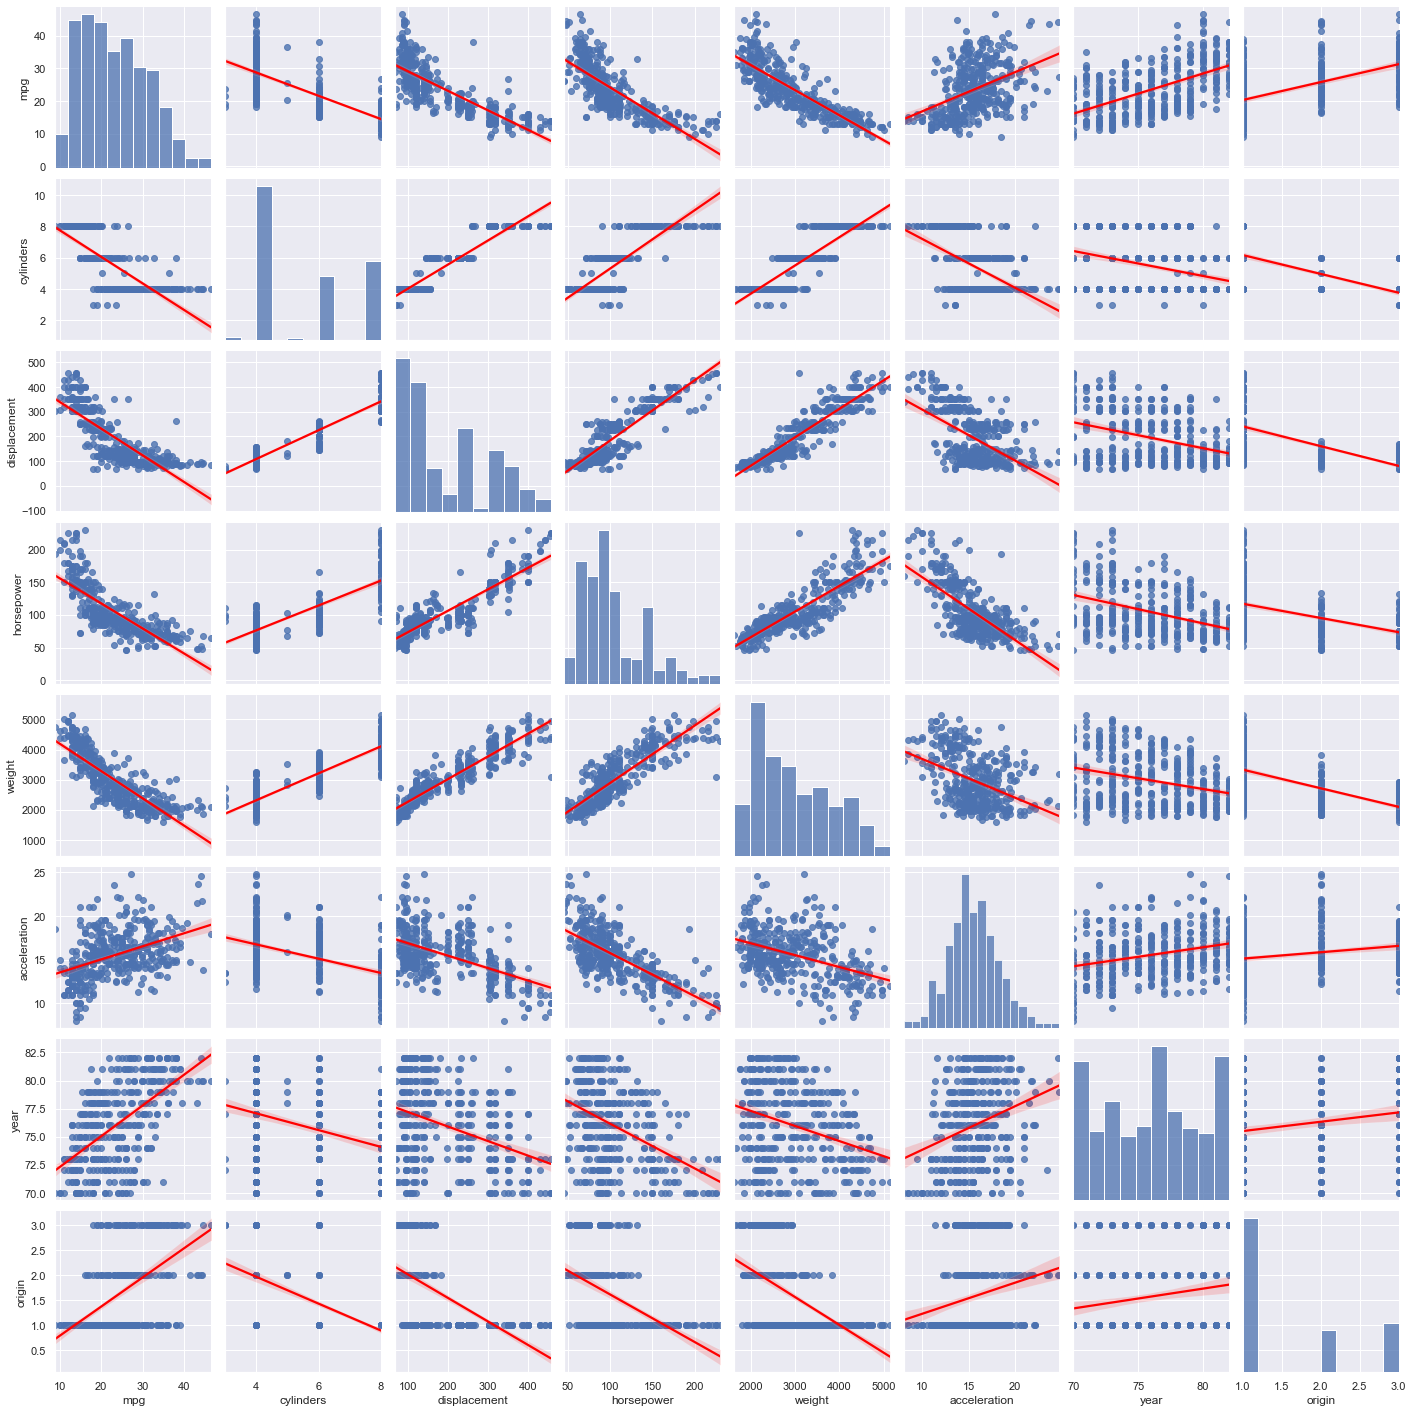

In [16]:
# convert horsepower to numeric
auto_df['horsepower'] = pd.to_numeric(auto_df['horsepower'])

# plot pairplot
g = sns.pairplot(auto_df, kind='reg', plot_kws={'line_kws':{'color':'red'}});

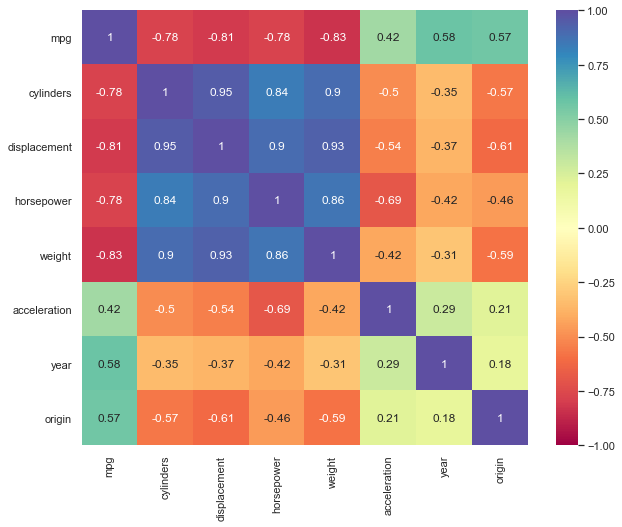

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(auto_df.corr(), vmin=-1, vmax=1, annot=True, cmap='Spectral');

>- **From the graphs above, we can see the correlations between variables. But still we can't tell if it's a Linear or a non-linear relationship.**
>- **Let's use a linear model then check if we can improve its accuracy by using degrees of freedom.**
>- **We are going to use the variable `mpg` as our response and the rest of variables as predictors.**

Min RMSE            : 3.5578019438659623
Best predictor count: 7


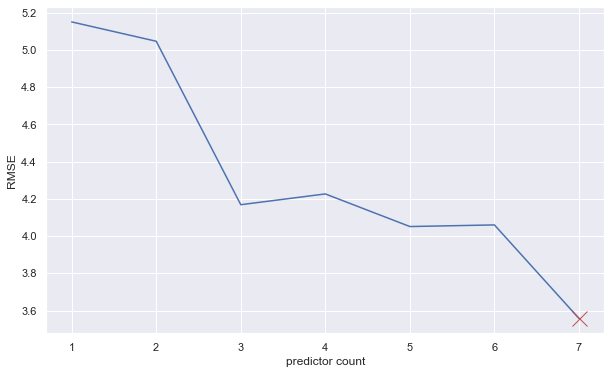

,predictor,selected
0,cylinders,True
1,displacement,True
2,horsepower,True
3,weight,True
4,acceleration,True
5,year,True
6,origin,True


In [18]:
X = auto_df.drop(['mpg', 'name'], axis=1)
y = auto_df.mpg

lr    = LinearRegression()
model = RFECV(lr, step=1, cv=10, scoring='neg_mean_squared_error')
model = model.fit(X, y)

# Best model stats
RMSEs_backward  = np.sqrt(np.abs(model.grid_scores_))
predictor_count = np.arange(1, 1+len(RMSEs_backward))
df = pd.DataFrame({'RMSE': RMSEs_backward, 'predictor count': predictor_count})
print('Min RMSE            : {}'.format(min(RMSEs_backward)))
print('Best predictor count: {}'.format(np.sum(model.support_)))

# Plot RMSE for each step
plt.figure(figsize=(10, 6))
sns.lineplot(x='predictor count', y='RMSE', data=df)
plt.plot(np.sum(model.support_), min(RMSEs_backward), 'rx', ms=15)
plt.show();

# Show selected features
display(pd.DataFrame({'predictor': X.columns,
                      'selected': model.ranking_ == 1}))

> **Backward stepwise selects a model with all features, reporting an $\text{RMSE}$ of $3.56$.**
> **Let's try now to to improve it with non-linear approaches:**

In [19]:
wid = widgets.Dropdown(
    options=['displacement', 'horsepower', 'weight', 'acceleration'],
    value='displacement',
    description='Number:',
    disabled=False)

def step_fun_ia(col):
    best_polynomial_degree(col, 'mpg', auto_df)

interact(step_fun_ia, col=wid);

interactive(children=(Dropdown(description='Number:', options=('displacement', 'horsepower', 'weight', 'accele…

>- **From the analysis above we could come with the result that there's a non-linear relationship between these $4$ variables and the response `mpg`.**
>- **Let's use the knowledge we got so far to fit a non-linear model and compare the accuracy so far:**

Min RMSE            : 3.007255621713537
Best predictor count: 19


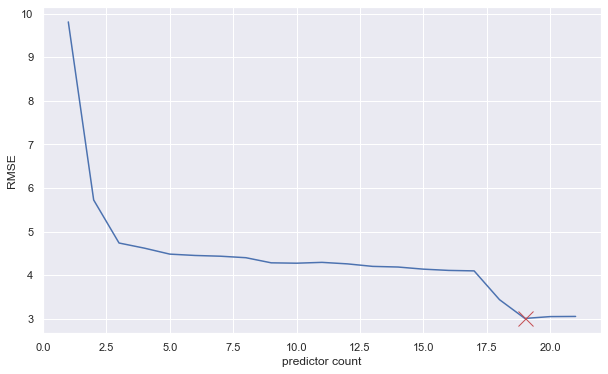

,predictor,selected
0,Intercept,True
1,C(cylinders)[T.4],True
2,C(cylinders)[T.5],True
3,C(cylinders)[T.6],True
4,C(cylinders)[T.8],True
5,C(origin)[T.2],False
6,C(origin)[T.3],True
7,"cr(displacement, df=3)[0]",True
8,"cr(displacement, df=3)[1]",True
9,"cr(displacement, df=3)[2]",True


In [20]:
# Create features
f = 'C(cylinders) + cr(displacement, df=3) + cr(horsepower, df=3) + cr(weight, df=3) + cr(acceleration, df=4) + year + C(origin)'
X = pt.dmatrix(f , auto_df)
y = np.asarray(auto_df['mpg'])

# Backward stepwise feature selection
lr = LinearRegression(fit_intercept=False)
model = RFECV(lr, step=1, cv=10, scoring='neg_mean_squared_error')
model = model.fit(X, y)

# Best model stats
RMSEs_backward  = np.sqrt(np.abs(model.grid_scores_))
predictor_count = np.arange(1, 1+len(RMSEs_backward))
df = pd.DataFrame({'RMSE': RMSEs_backward, 'predictor count': predictor_count})
print('Min RMSE            : {}'.format(min(RMSEs_backward)))
print('Best predictor count: {}'.format(np.sum(model.support_)))

# Plot RMSE for each step
plt.figure(figsize=(10, 6))
sns.lineplot(x='predictor count', y='RMSE', data=df)
plt.plot(np.sum(model.support_), min(RMSEs_backward), 'rx', ms=15)
plt.show();

# Show selected features
display(pd.DataFrame({'predictor': X.design_info.column_names,
                      'selected': model.ranking_ == 1}))

>**Comments:**
>- Backward stepwise selects a model with all features except $2$ predictors, reporting an $\text{RMSE}$ of $3.00$. which is a remarkable improvement on the best $\text{RMSE}$ achieved for the linear regression with all variables: $3.56$, which is $15.73\%$ accuracy improvement!
>- Even backward stepwise selection doesn't seem to be appropriately selecting the optimal variables for the best model, we got a satisfying improvement.

<a id='9'></a>
### $9.$ This question uses the variables $\color{red}{\text{dis}}$ (the weighted mean of distances to five Boston employment centers) and $\color{red}{\text{nox}}$ (nitrogen oxides concentration in parts per $10$ million) from the $\color{red}{\text{Boston}}$ data. We will treat $\color{red}{\text{dis}}$ as the predictor and $\color{red}{\text{nox}}$ as the response.

<a id='9a'></a>
**$(a)$ Use the `poly()` function to fit a cubic polynomial regression to predict $\color{red}{\text{nox}}$ using $\color{red}{\text{dis}}$. Report the regression output, and plot the resulting data and polynomial fits.**

In [21]:
# read boston dataset
boston_df = pd.read_csv('datasets/Boston.csv').drop('Unnamed: 0', axis=1)

f = 'dis + np.power(dis, 2) + np.power(dis, 3)'
X = pt.dmatrix(f, boston_df) # the predictor
y = boston_df.nox # the response

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    nox   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     419.3
Date:                Thu, 14 Oct 2021   Prob (F-statistic):          2.71e-136
Time:                        15:26:27   Log-Likelihood:                 690.44
No. Observations:                 506   AIC:                            -1373.
Df Residuals:                     502   BIC:                            -1356.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9341      0.021     45.110      0.0

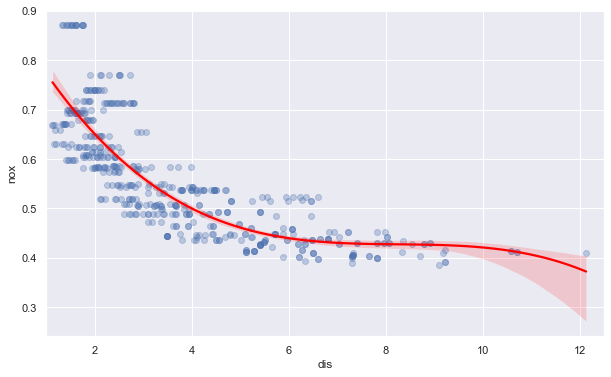

In [22]:
# plot the polynomial fit line for the 3rd degree 
plt.figure(figsize=(10,6))
ax = sns.regplot(x="dis", y="nox", data=boston_df,
                 scatter_kws={'alpha':0.3}, line_kws={"color": "red"}, order=3);
ax.set(xlim=(1, 12.5));

> **Comments:**
>- **Summary shows that all polynomial terms are significant while predicting the response `nox` using `dis`.**
>- **Plot shows a smooth curve fitting the data fairly well, but we can see the limitations in the tails with a few observations.**

<a id='9b'></a>
**$(b)$ Plot the polynomial fits for a range of different polynomial degrees (say, from $1$ to $10$), and report the associated residual sum of squares.**

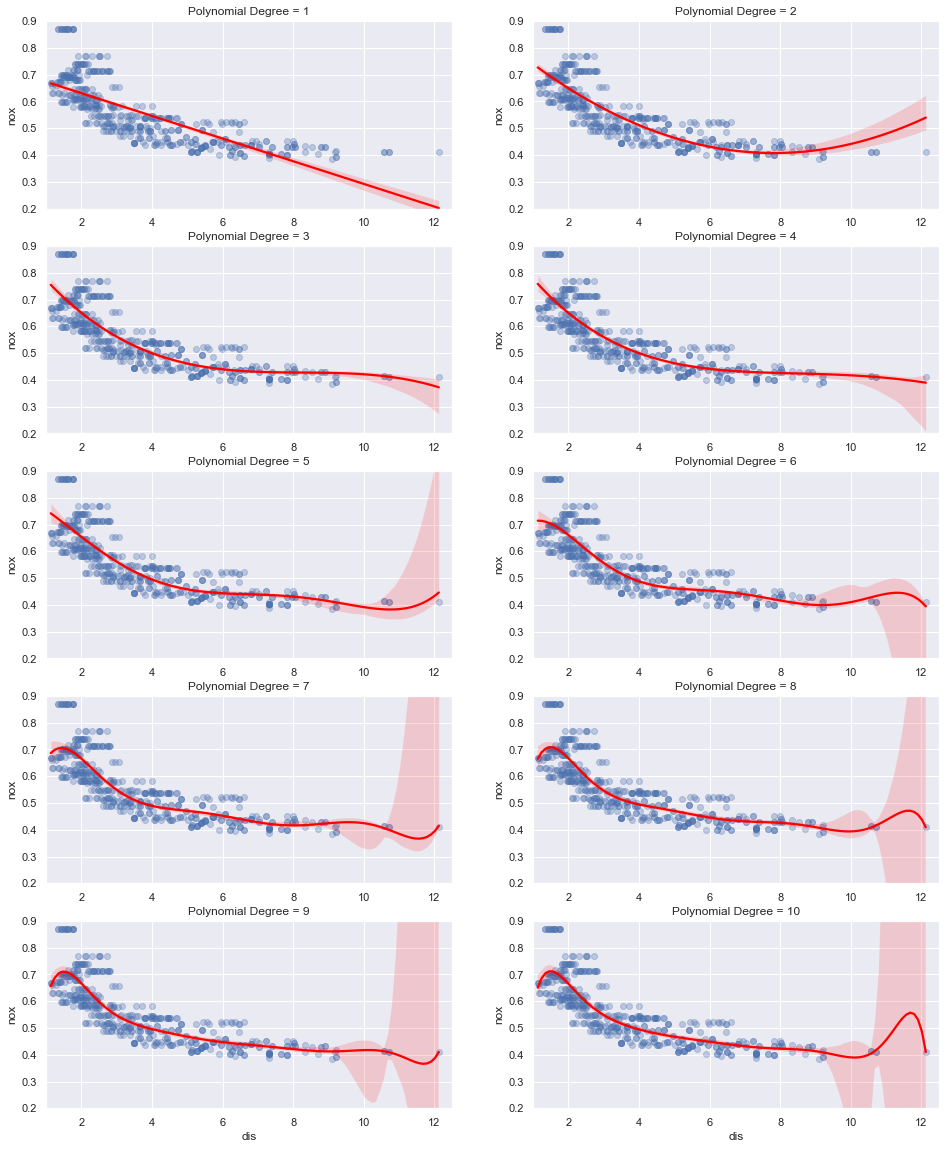

In [23]:
fig, axs = plt.subplots(5, 2, figsize=(16,20))

for i in range(5):
    # plot the polynomial fit line for the 3rd degree 
    # col #1
    sns.regplot(x="dis", y="nox", data=boston_df,
                scatter_kws={'alpha':0.3}, line_kws={"color": "red"},
                order=i*2+1, ax=axs[i, 0])
    axs[i, 0].set(xlabel='', xlim=(1, 12.5), ylim=(0.2, 0.9),
                  title= f"Polynomial Degree = {i*2+1}");
    
    # col #2
    sns.regplot(x="dis", y="nox", data=boston_df,
                scatter_kws={'alpha':0.3}, line_kws={"color": "red"},
                order=i*2+2, ax=axs[i, 1])
    axs[i, 1].set(xlabel='', xlim=(1, 12.5), ylim=(0.2, 0.9),
                  title= f"Polynomial Degree = {i*2+2}");
    
plt.setp(axs[-1, :], xlabel='dis');

[[6.780956037648222, 1],
 [2.768562858969277, 2],
 [2.0352618689352555, 3],
 [1.9341067071790707, 4],
 [1.9329813272985945, 5],
 [1.9152899610843037, 6],
 [1.8782572985081685, 7],
 [1.849483614583015, 8],
 [1.8356296890677393, 9],
 [1.8333308045025316, 10]]

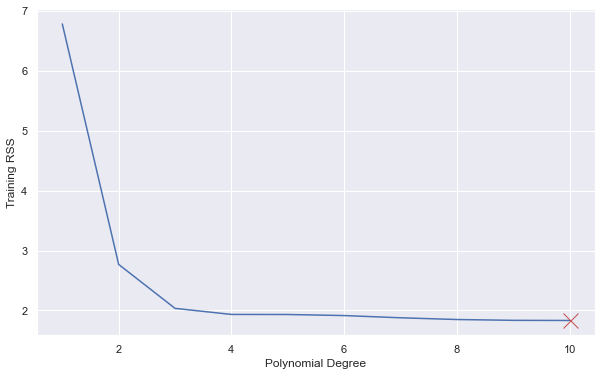

In [24]:
degree = 10
f = ' + '.join(['np.power(dis, {})'.format(i) for i in np.arange(1, degree+1)])
X = pt.dmatrix(f, boston_df)

res = []
for i in range(10):
    # fit Model
    model = sm.OLS(y, X[:, 0:i+1])
    results = model.fit()
    res.append([results.ssr, i+1])
    
# the minimum training RSS
m = min(res)

# ploting the results
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=[r[0] for r in res])
plt.xlabel("Polynomial Degree")
plt.ylabel("Training RSS")
plt.plot(m[1], m[0], 'rx', ms=15);
display(res)

> **Comments:**
>- As expected, train $\text{RSS}$ monotonically decreases as flexibility increases ("Which overfit the training set").

<a id='9c'></a>
**$(c)$ Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results.**

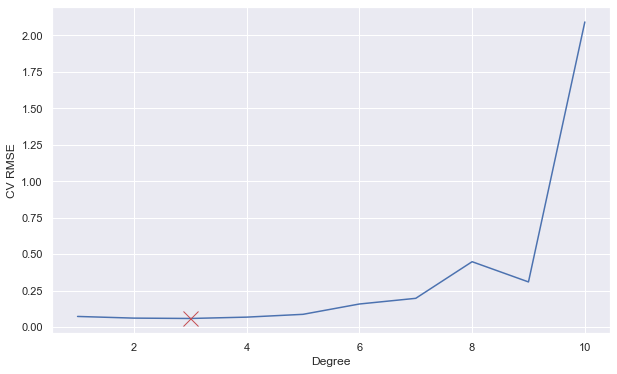

Min RMSE : 0.06115394767838447
Degree   : 3


In [25]:
# check which degree perform better
best_polynomial_degree('dis', 'nox', boston_df, 11)

>- We can see from the plot above that with higher degree of polynomial, it perform worse in the test set as the model overfit the training set with higher order of polynomial, which the $\text{RSME}$ increase in this case as flexibility increase.

<a id='9d'></a>
**$(d)$ Use the `bs()` function to fit a regression spline to predict $\color{red}{\text{nox}}$ using $\color{red}{\text{dis}}$. Report the output for the fit using four degrees of freedom. How did you choose the knots? Plot the resulting fit.**

>**Answer:**
>- From page $273$, the author explained the most direct way to represent a cubic spline using the formula $(7.9)$ is to start off with a basis for a cubic polynomial $x, x^2, x^3$ and then add one truncated power basis function per knot.
>- Means for four degrees of freedom the spline formula would look like:
$$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3$$
>- As $K$ equal to $(\text{Degrees of freedom} - 4)$, we are using here $4$ degrees of freedom so $K = 4 - 4 = 0$.
>- **How did you choose the knots?**
>- From the explanation above, $0$ knots were chosen.
>- Thus, we are going to fit a regular cubic polynomial model.

In [26]:
import scipy.interpolate as intrp
import matplotlib.pyplot as plt
import patsy # for comparison

def bspline(X, y, k=0):
    '''Fit a spline model with k knots
    return: OLS fitted model, y_hat and knots [model, y_hat, knots]'''
    # automatically place the corresponding number of knots
    knots = np.quantile(X, np.arange(0, 1, 1/(k+1))[1:])

    # in Patsy/R: nice and sensible
    X = patsy.bs(X, knots=knots, degree=3, include_intercept=True)
    X.columns = ['x'+str(c) for c in X.columns]

    model = sm.OLS(y, X).fit()
    y_hat = model.predict(X)
    return model, y_hat, knots
    
model, y_hat, _ = bspline(boston_df.dis, boston_df.nox, 0)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    nox   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     419.3
Date:                Thu, 14 Oct 2021   Prob (F-statistic):          2.71e-136
Time:                        15:26:50   Log-Likelihood:                 690.44
No. Observations:                 506   AIC:                            -1373.
Df Residuals:                     502   BIC:                            -1356.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x0             0.7552      0.008     91.168      0.0

In [27]:
# for Visualizing the model fit but as k=0, I'll use the regplot for better vis
#sns.scatterplot(x='dis', y='nox', data=boston_df);
#sns.lineplot(x=boston_df.dis, y=y_hat, color='red');
#for k in knots:
#    plt.axvline(k, linestyle='--', color='green');

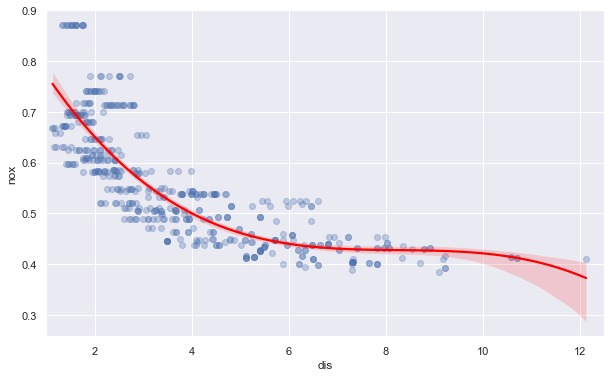

In [28]:
# Visualizing the fit with 0 Knots
plt.figure(figsize=(10, 6))  
ax = sns.regplot(x="dis", y="nox", data=boston_df,
            scatter_kws={'alpha':0.3}, line_kws={"color": "red"},
            order=3)
ax.set(xlim=(1, 12.5));

>**Note:**
>- One way to select knot is to specify the desired degrees of freedom, and then have the software automatically place the corresponding number of knots at uniform quantiles of the data. 
>- I already have done the automation in the code above.

<a id='9e'></a>
**$(e)$ Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting $\text{RSS}$. Describe the results obtained.**

>**Answer:**
>- Let's set the range of degrees of freedom between $(4:13)$, which are the knots range of $(0:9)$.

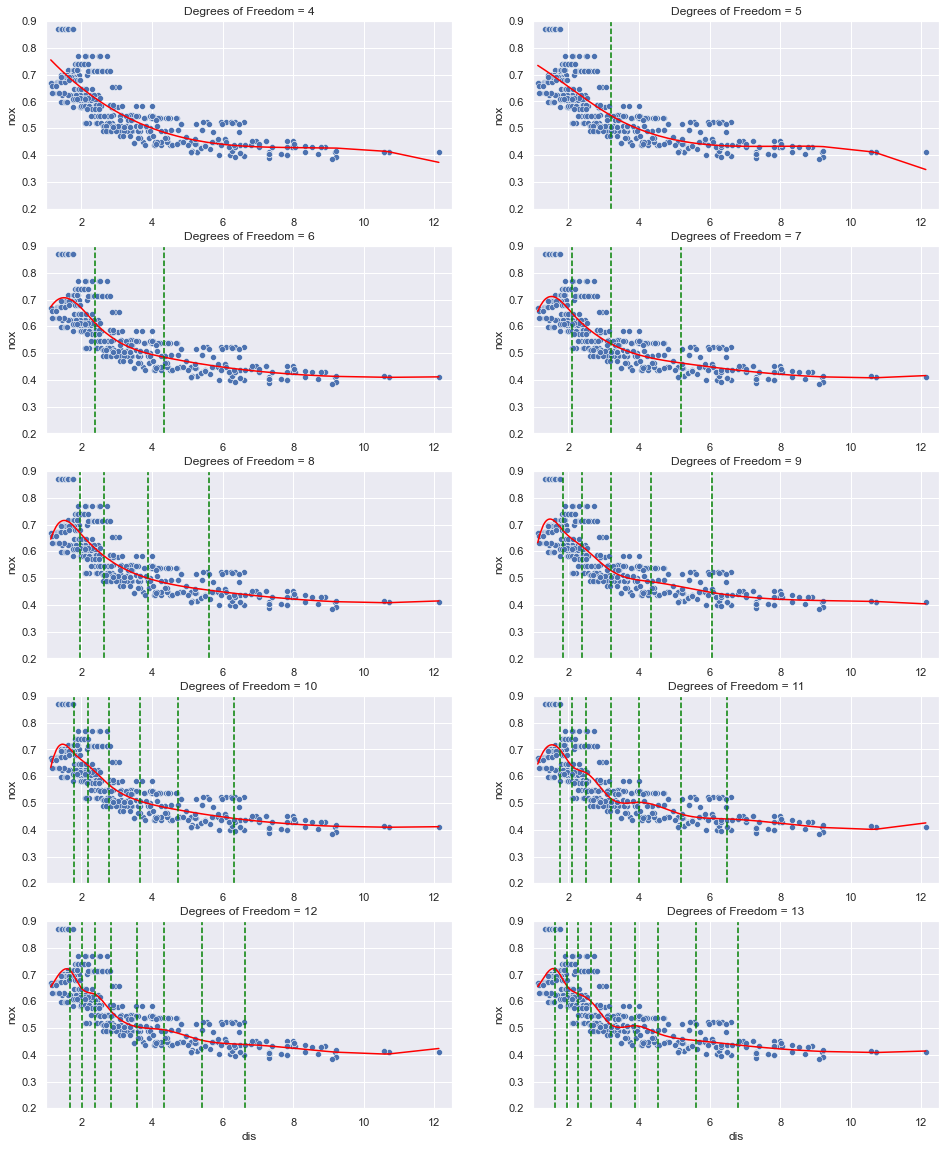

In [29]:
res = []
fig, axs = plt.subplots(5, 2, figsize=(16,20))

for i in range(5):
    model, y_hat, knots= bspline(boston_df.dis, boston_df.nox, i*2)
    res.append([model.ssr, (i*2)+4])
    
    sns.scatterplot(x='dis', y='nox', data=boston_df, ax=axs[i, 0])
    sns.lineplot(x=boston_df.dis, y=y_hat, color='red', ax=axs[i, 0])
    axs[i, 0].set(xlabel='', xlim=(1, 12.5), ylim=(0.2, 0.9),
                  title= f"Degrees of Freedom = {i*2+4}")
    
    for k in knots:
        axs[i, 0].axvline(k, linestyle='--', color='green')    

    model, y_hat, knots= bspline(boston_df.dis, boston_df.nox, i*2+1)
    res.append([model.ssr, (i*2)+5])
    
    sns.scatterplot(x='dis', y='nox', data=boston_df, ax=axs[i, 1])
    sns.lineplot(x=boston_df.dis, y=y_hat, color='red', ax=axs[i, 1])
    axs[i, 1].set(xlabel='', xlim=(1, 12.5), ylim=(0.2, 0.9),
                  title= f"Degrees of Freedom = {i*2+5}")
    
    for k in knots:
        axs[i, 1].axvline(k, linestyle='--', color='green');
        
plt.setp(axs[-1, :], xlabel='dis');

[[1.934106707179071, 4],
 [1.9227749928119258, 5],
 [1.8401728014885237, 6],
 [1.8339659031602094, 7],
 [1.8298844459232841, 8],
 [1.8169950567252335, 9],
 [1.8256525103870564, 10],
 [1.7925348895561346, 11],
 [1.7969918217314271, 12],
 [1.788999145288884, 13]]

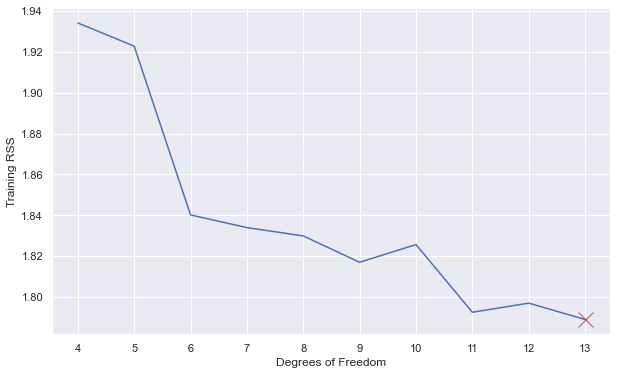

In [30]:
# the minimum training RSS
m = min(res)

# ploting the training MSE results
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(4, 14), y=[r[0] for r in res])
plt.xlabel("Degrees of Freedom")
plt.ylabel("Training RSS")
plt.xticks([r[1] for r in res])

plt.plot(m[1], m[0], 'rx', ms=15);
display(res)

>**Comments:**
>- Training $\text{RSS}$ monotonically decreases till Degrees of Freedom of $13$.
>- It appears from the graphs above that while number of knots increase, the model doesn't like overfitting the data as expected.

<a id='9f'></a>
**$(f)$ Perform cross-validation or another approach in order to select the best degrees of freedom for a regression spline on this data. Describe your results.**

[[0.004222893611150249, 4],
 [0.005354844744372111, 5],
 [0.0046593276806649615, 6],
 [0.004702749993074255, 7],
 [0.004959029431752861, 8],
 [0.005303640580570454, 9],
 [0.005183706014416815, 10],
 [0.005497022083455383, 11],
 [0.0058668896600879185, 12],
 [0.00517691832994955, 13]]

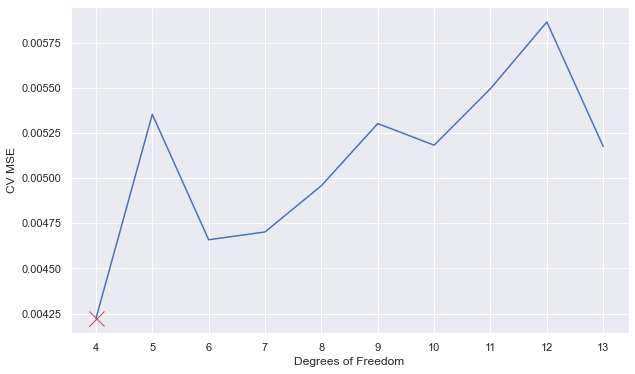

In [31]:
results = []
y = boston_df.nox

for k in range(10):
    
    #'''Fit a spline model with k knots
    #return: OLS fitted model, y_hat and knots [model, y_hat, knots]'''
    # automatically place the corresponding number of knots
    knots = np.quantile(boston_df.dis, np.arange(0, 1, 1/(k+1))[1:])

    # in Patsy/R: nice and sensible
    X = patsy.bs(boston_df.dis, knots=knots, degree=3)
    X.columns = ['x'+str(c) for c in X.columns]

    # fit model
    lr = LinearRegression(fit_intercept=True)
    scores = cross_val_score(lr, X, y, cv=10, scoring='neg_mean_squared_error')
    results.append([np.mean(np.abs(scores)), k+4])
    
# the minimum training RSS
m = min(results)

# ploting the training MSE results
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(4, 14), y=[r[0] for r in results])
plt.xlabel("Degrees of Freedom")
plt.ylabel("CV MSE")
plt.xticks([r[1] for r in results])

plt.plot(m[1], m[0], 'rx', ms=15);
display(results)

>**Comments:**
>- From the graph above we can tell that regression spline approach has not affect for better performance, as the best obtained $\text{CV-MSE}$ was a cubic spline with $4$ Degrees of Freedom which is 0 knots spline, with $\text{CV-MSE}$ of $0.00422$.

<a id='10'></a>
### $10.$ This question relates to the $\color{red}{\text{College}}$ data set.

<a id='10a'></a>
**$(a)$ Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.**

In [32]:
collage_df = pd.read_csv('datasets/College.csv').drop('Unnamed: 0', axis=1)
collage_df.columns = [c.replace('.', '_') for c in collage_df.columns]
collage_df_d = pd.get_dummies(collage_df, drop_first=True)

collage_df_d.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate,Private_Yes
0,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1
1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1
2,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1
3,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1
4,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1


In [33]:
X_10 = collage_df_d.drop('Outstate', axis=1) # the predictors
y_10 = collage_df_d.Outstate # the response

X_train, X_test, y_train, y_test = train_test_split(X_10, y_10,
                                                    test_size=0.3,
                                                    random_state=42)

train = X_train.copy()
train['Outstate'] = y_train

### Forward Stepwise Selection:

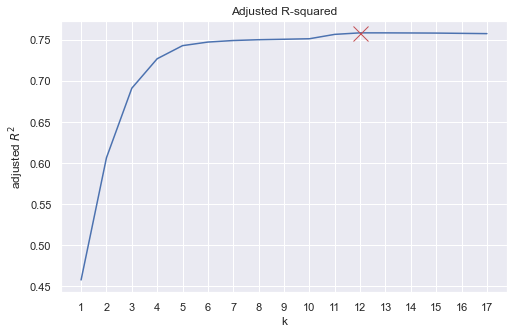

Model selected coefficients: 
Intercept     -3104.265308
Expend            0.224364
Private_Yes    2585.311934
Room_Board        0.976661
perc_alumni      47.478185
PhD              12.933617
Grad_Rate        18.776464
Terminal         21.225516
Top25perc        16.026115
S_F_Ratio       -37.484696
Accept            0.776336
Apps             -0.370419
Enroll           -0.649645
dtype: float64
----------------------------------------------------



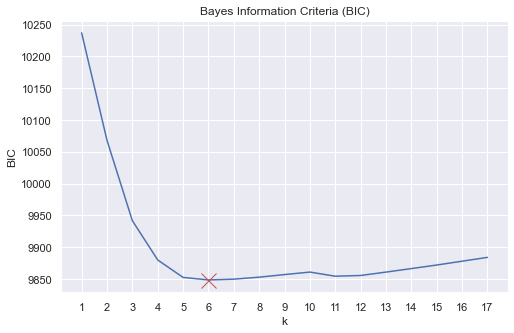

Model selected coefficients: 
Intercept     -3367.495333
Expend            0.228699
Private_Yes    2792.072581
Room_Board        1.028953
perc_alumni      52.189684
PhD              35.974269
Grad_Rate        20.349510
dtype: float64
----------------------------------------------------



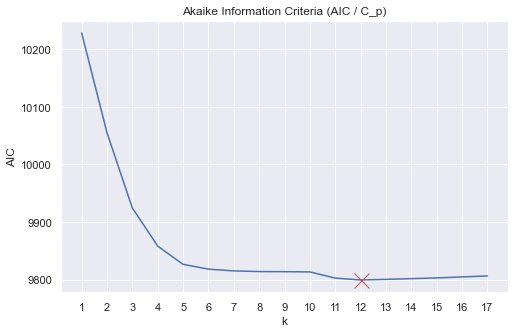

Model selected coefficients: 
Intercept     -3104.265308
Expend            0.224364
Private_Yes    2585.311934
Room_Board        0.976661
perc_alumni      47.478185
PhD              12.933617
Grad_Rate        18.776464
Terminal         21.225516
Top25perc        16.026115
S_F_Ratio       -37.484696
Accept            0.776336
Apps             -0.370419
Enroll           -0.649645
dtype: float64


In [34]:
model_subsets_fs, _ = forward_stepwise(train.columns.drop(['Outstate']), 'Outstate', train)
scores_plot(model_subsets_fs)

>**Comments:**
>- Forward stepwise Selection by using $BIC$ as the error evaluation has selected 6 predictors for the satisfactory model which are: $\text{(Expend, Private_Yes, Room_Board, perc_alumni, PhD, Grad_Rate)}$.

### Let's try Best Subset Selection:
**Note: This is a long process with 18 features and 777 observations, which the cell below took approx 41 minutes to run!**

In [35]:
t = '''Progess: k = 1, done, time: 0.1173 s
Progess: k = 2, done, time: 1.0317 s
Progess: k = 3, done, time: 6.1357 s
Progess: k = 4, done, time: 26.2782 s
Progess: k = 5, done, time: 83.4713 s
Progess: k = 6, done, time: 185.732 s
Progess: k = 7, done, time: 309.6532 s
Progess: k = 8, done, time: 426.6156 s
Progess: k = 9, done, time: 475.0024 s
Progess: k = 10, done, time: 418.1777 s
Progess: k = 11, done, time: 294.2277 s
Progess: k = 12, done, time: 152.7395 s
Progess: k = 13, done, time: 63.0957 s
Progess: k = 14, done, time: 18.8509 s
Progess: k = 15, done, time: 4.0612 s
Progess: k = 16, done, time: 0.5497 s
Progess: k = 17, done, time: 0.0519 s'''

t = sum(map(float, [te.split(':')[-1][1:-2] for te in t.split('\n')]))/60
print(f"It took about {round(t)} minutes to run!")

It took about 41 minutes to run!


Progess: k = 1, done, time: 0.1173 s
Progess: k = 2, done, time: 1.0317 s
Progess: k = 3, done, time: 6.1357 s
Progess: k = 4, done, time: 26.2782 s
Progess: k = 5, done, time: 83.4713 s
Progess: k = 6, done, time: 185.732 s
Progess: k = 7, done, time: 309.6532 s
Progess: k = 8, done, time: 426.6156 s
Progess: k = 9, done, time: 475.0024 s
Progess: k = 10, done, time: 418.1777 s
Progess: k = 11, done, time: 294.2277 s
Progess: k = 12, done, time: 152.7395 s
Progess: k = 13, done, time: 63.0957 s
Progess: k = 14, done, time: 18.8509 s
Progess: k = 15, done, time: 4.0612 s
Progess: k = 16, done, time: 0.5497 s
Progess: k = 17, done, time: 0.0519 s


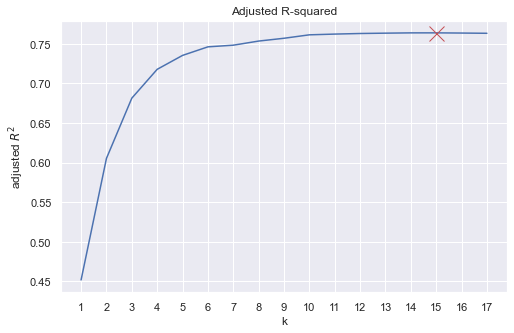

Model selected coefficients: 
Intercept     -1647.456229
Apps             -0.299433
Accept            0.802289
Enroll           -0.536648
Top10perc        24.278763
F_Undergrad      -0.095096
Room_Board        0.883649
Books            -0.463780
Personal         -0.226767
PhD              11.343333
Terminal         24.171159
S_F_Ratio       -46.388747
perc_alumni      41.553482
Expend            0.200927
Grad_Rate        23.646509
Private_Yes    2263.196367
dtype: float64
----------------------------------------------------



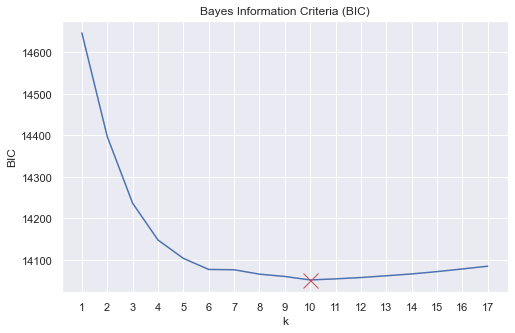

Model selected coefficients: 
Intercept     -3253.000896
Apps             -0.302073
Accept            0.760917
Top10perc        24.910385
F_Undergrad      -0.188751
Room_Board        0.906401
Terminal         33.992035
perc_alumni      44.098644
Expend            0.214683
Grad_Rate        25.286472
Private_Yes    2317.250251
dtype: float64
----------------------------------------------------



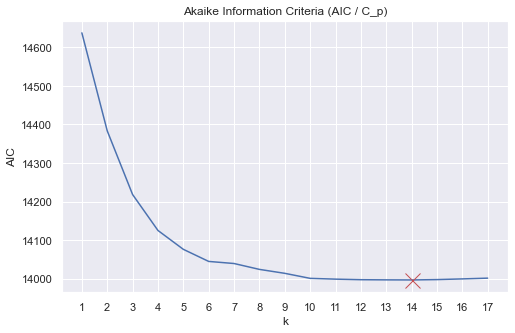

Model selected coefficients: 
Intercept     -1817.040106
Apps             -0.299902
Accept            0.802352
Enroll           -0.537255
Top10perc        23.655285
F_Undergrad      -0.095699
Room_Board        0.874182
Personal         -0.247842
PhD              12.695061
Terminal         22.972959
S_F_Ratio       -47.005597
perc_alumni      41.950060
Expend            0.200391
Grad_Rate        23.831969
Private_Yes    2256.945524
dtype: float64


In [43]:
model_subsets = best_subset(X=df.columns.drop(['Outstate']), y='Outstate', data=collage_df_d)
scores_plot(model_subsets)

<a id='10b'></a>
**$(b)$ Fit a $\text{GAM}$ on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.**

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


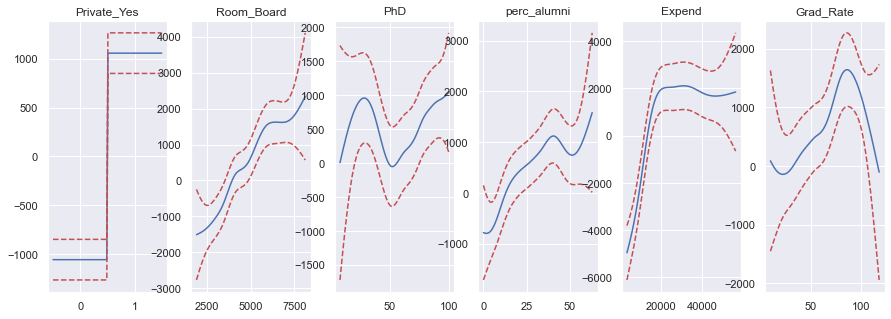

In [38]:
from pygam import LinearGAM, s, f, l

X_train6 = X_train[['Private_Yes', 'Room_Board', 'PhD', 'perc_alumni', 'Expend', 'Grad_Rate']].to_numpy()
X_test6  = X_test[['Private_Yes', 'Room_Board', 'PhD', 'perc_alumni', 'Expend', 'Grad_Rate']].to_numpy()

## model
gam = LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5))
gam.gridsearch(X_train6, y_train)

## plotting
fig, axs = plt.subplots(1,6, figsize=(15, 5));

titles = ['Private_Yes', 'Room_Board', 'PhD', 'perc_alumni', 'Expend', 'Grad_Rate']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

> **Comments:**
>- We fit a $GAM$ with the chosen predictors from the forward selection, which are **Private_Yes, Room_Board, PhD, perc_alumni, Expend, Grad_Rate**.
>- It seems that there's a non-linear relationship with these five predictors. 

<a id='10c'></a>
**$(c)$ Evaluate the model obtained on the test set, and explain the results obtained.**

In [39]:
y_hat_gam = gam.predict(X_test6)

print("GAM test R2: ", round(metrics.r2_score(y_test, y_hat_gam), 4))
print("GAM test MSE:", round(metrics.mean_squared_error(y_test, y_hat_gam), 2))

GAM test R2:  0.7552
GAM test MSE: 3900526.46


In [40]:
l_model = LinearRegression().fit(X_train6, y_train)
y_hat_l = l_model.predict(X_test6)

print("Linear test R2: ", round(metrics.r2_score(y_test, y_hat_l), 4))
print("Linear test MSE:", round(metrics.mean_squared_error(y_test, y_hat_l), 2))

Linear test R2:  0.7367
Linear test MSE: 4196427.88


> **Comments:**
>- Comparing to the linear model on the test set, the $GAM$ model has a better test performance.

<a id='10d'></a>
**$(d)$ For which variables, if any, is there evidence of a non-linear relationship with the response?**

In [41]:
# Derive 5 degree polynomial features of age
for t in titles[1:]:
    degree = 5
    f = ' + '.join([f'np.power({t}, {i})' for i in np.arange(1, degree+1)])
    X = pt.dmatrix(f, collage_df)
    y = np.asarray(collage_df['Outstate'])

    # Get models of increasing degrees
    model_1 = sm.OLS(y, X[:, 0:2]).fit()
    model_2 = sm.OLS(y, X[:, 0:3]).fit()
    model_3 = sm.OLS(y, X[:, 0:4]).fit()
    model_4 = sm.OLS(y, X[:, 0:5]).fit()
    model_5 = sm.OLS(y, X[:, 0:6]).fit()

    # Compare models with ANOVA
    res = sm.stats.anova_lm(model_1, model_2, model_3, model_4, model_5)
    print(t)
    display(res[res['Pr(>F)'] < 0.001])

Room_Board


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)


PhD


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,774.0,9.757922e+09,1.0,9.592343e+08,76.915128,1.123779e-17
2,773.0,9.619346e+09,1.0,1.385760e+08,11.111565,8.987506e-04


perc_alumni


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)


Expend


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,774.0,5.142091e+09,1.0,1.732478e+09,75.998848,1.714218e-17


Grad_Rate


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
2,773.0,8.185681e+09,1.0,2.394597e+08,22.64579,0.000002


> **Comments:**
>- We can say from the Anova test above that the predictors **PhD, Expend, and Grad_Rate** have evidence of a non-linear relationship with the response **Outstate**

Let's take a look at their correlation with **Outstate**.

In [42]:
collage_df[['Outstate', 'Room_Board', 'PhD', 'perc_alumni', 'Expend', 'Grad_Rate']].corr()[['Outstate']]

,Outstate
Outstate,1.000000
Room_Board,0.654256
PhD,0.382982
perc_alumni,0.566262
Expend,0.672779
Grad_Rate,0.571290


>- We can say that their correlation with the response is between `Moderate` and `Low`, thus for me, we can't tell if the relationship is linear or non-linear.

Finally, let's plot the response against these predictors to get a clear view:

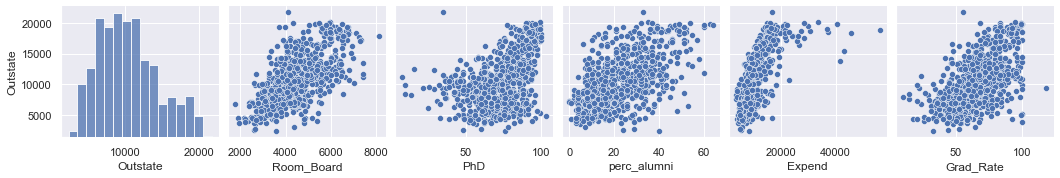

In [43]:
cols = ['Outstate', 'Room_Board', 'PhD', 'perc_alumni', 'Expend', 'Grad_Rate']
sns.pairplot(collage_df[cols], y_vars='Outstate');

<a id='11'></a>
### $11.$ In Section $7.7$, it was mentioned that $\text{GAMs}$ are generally fit using a $\text{backfitting}$ approach. The idea behind back fitting is actually quite simple. We will now explore back fitting in the context of multiple linear regression. <br><br> Suppose that we would like to perform multiple linear regression, but we do not have software to do so. Instead, we only have software to perform simple linear regression. Therefore, we take the following iterative approach: we repeatedly hold all but one coefficient estimate fixed at its current value, and update only that coefficient estimate using a simple linear regression. The process is continued until *convergence*—that is, until the coefficient estimates stop changing.

### We now try this out on a toy example.

<a id='11a'></a>
**$(a)$ Generate a response $Y$ and two predictors $X_1$ and $X_2$, with $n = 100$.**

<a id='11b'></a>
**$(b)$ Initialize $\hat{\beta}_1$ to take on a value of your choice. It does not matter
what value you choose.**

In [44]:
np.random.seed(1)
x1  = np.random.normal(0, 1, 100)
x2  = np.random.normal(0, 1, 100)
b1  = 3
b2  = 6
eps = 0.1 * np.random.normal(0, 1, 100)

X = np.asarray([np.ones(100), x1, x2]).T
y = 0.5 + b1*x1 + b2*x2 + eps

<a id='11c'></a>
**$(c)$ Keeping $\hat{\beta}_1$ fixed, fit the model**
$$y − β_1 X_1 = β_0 + β_2 X_2 + ε$$
**You can do this as follows:**<br>
`> a=y-beta1 *x1`<br>
`> beta2=lm(a∼x2)$coef [2]`

In [45]:
a = y - b1 * x1
b2 = sm.OLS(a, np.asarray([np.ones(100), x2]).T).fit().params[1]
print(b2)

6.02130434505542


<a id='11d'></a>
**$(d)$ Keeping $β_2$ fixed, fit the model** 
$$y − β_2 X_2 = β_0 + β_1 X_1 + ε$$

In [46]:
a = y - b2 * x2
b1 = sm.OLS(a, np.asarray([np.ones(100), x1]).T).fit().params[1]
print(b1)

2.9938611183572106


<a id='11e'></a>
**$(e)$ Write a for loop to repeat $(c)$ and $(d)$ $1,000$ times. Report the estimates of $\hat{\beta}_0$, $\hat{\beta}_1$, and $\hat{\beta}_2$ at each iteration of the for loop. Create a plot in which each of these values is displayed, with $\hat{\beta}_0$, $\hat{\beta}_1$, and $\hat{\beta}_2$ each shown in a different color.**

In [47]:
results= []
for i in range(1000):
    a = y - b1 * x1
    b2 = sm.OLS(a, np.asarray([np.ones(100), x2]).T).fit().params[1]
    
    a = y - b2 * x2
    params = sm.OLS(a, np.asarray([np.ones(100), x1]).T).fit().params
    b0 = params[0]
    b1 = params[1]
    results.append([b0, b1, b2])

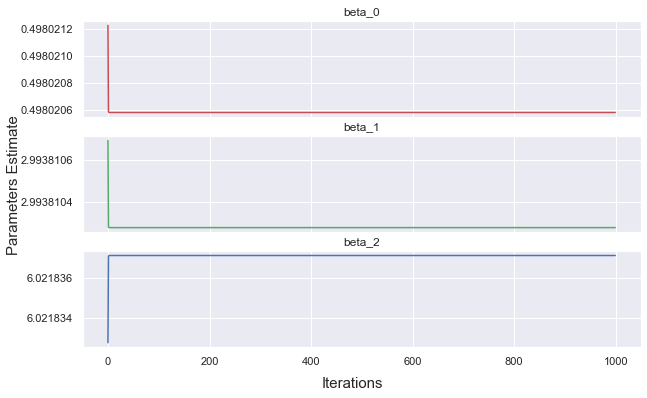

In [48]:
fig, axs = plt.subplots(3, 1, figsize=(10,6), sharex=True)
# Set common labels
fig.text(0.5, 0.04, 'Iterations', ha='center', va='center', size=15)
fig.text(0.03, 0.5, 'Parameters Estimate', ha='center', va='center', rotation='vertical', size=15)

colors = ['r', 'g', 'b']
for i in range(3):
    axs[i].plot(np.arange(0, 1000), np.array(results)[:,i], colors[i])
    axs[i].ticklabel_format(useOffset=False)
    axs[i].title.set_text(f'beta_{i}')

### For a closer look:

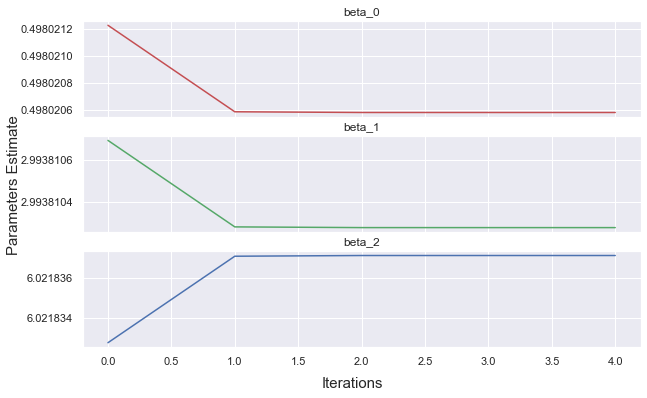

In [49]:
fig, axs = plt.subplots(3, 1, figsize=(10,6), sharex=True)
# Set common labels
fig.text(0.5, 0.04, 'Iterations', ha='center', va='center', size=15)
fig.text(0.03, 0.5, 'Parameters Estimate', ha='center', va='center', rotation='vertical', size=15)

colors = ['r', 'g', 'b']
for i in range(3):
    axs[i].plot(np.arange(0, 5), np.array(results)[:5,i], colors[i])
    axs[i].ticklabel_format(useOffset=False)
    axs[i].title.set_text(f'beta_{i}')

>- The question explains how this process continues till `convergence`, where the estimated coefficients stay still. From the graph above we can see the convergence happened after the first step.

<a id='11f'></a>
**$(f)$ Compare your answer in $(e)$ to the results of simply performing multiple linear regression to predict $Y$ using $X_1$ and $X_2$. Use the `abline()` function to overlay those multiple linear regression coefficient estimates on the plot obtained in $(e)$.**

In [50]:
coefs = sm.OLS(y, np.asarray([np.ones(100), x1, x2]).T).fit().params
coefs

array([0.49802058, 2.99381028, 6.02183714])

>- Overlaying these coefficients onto the previous plot (with a black dashed line), it appears that the multiple linear regression to predict Y using X1 and X2 gave the same or pretty close coefficient estimates to those provided by the looped simple linear regressions once they had convergence.

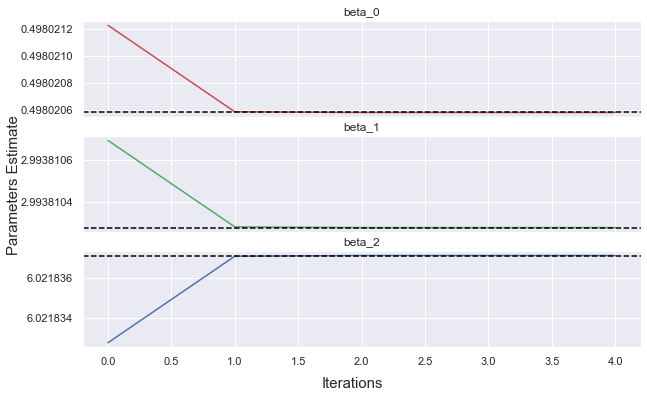

In [51]:
fig, axs = plt.subplots(3, 1, figsize=(10,6), sharex=True)
# Set common labels
fig.text(0.5, 0.04, 'Iterations', ha='center', va='center', size=15)
fig.text(0.03, 0.5, 'Parameters Estimate', ha='center', va='center', rotation='vertical', size=15)

colors = ['r', 'g', 'b']
for i in range(3):
    axs[i].plot(np.arange(0, 5), np.array(results)[:5,i], colors[i])
    axs[i].axhline(y=coefs[i], color='black', linestyle='--')
    axs[i].ticklabel_format(useOffset=False)
    axs[i].title.set_text(f'beta_{i}')

<a id='11g'></a>
**$(g)$ On this data set, how many backfitting iterations were required in order to obtain a “good” approximation to the multiple regression coefficient estimates?**

>- It required **two** iterations to obtain a good approximation to the multiple regression coefficient estimates.

<a id='12'></a>
### $12.$ This problem is a continuation of the previous exercise. In a toy example with $p = 100$, show that one can approximate the multiple linear regression coefficient estimates by repeatedly performing simple linear regression in a backfitting procedure. How many backfitting iterations are required in order to obtain a “good” approximation to the multiple regression coefficient estimates? Create a plot to justify your answer.

In [52]:
def gen_data(n, p):
    """Generate simulated data from normal distribution where:
    - n is number of observations
    - p is number of predictors
    
    Returns
    X, design matrix of predictors with bias variable
    y, response variable from linear model
    beta_true, the true coefficients of the linear model used to derive y from X
    beta_rand, a random vector of shape beta_true, useful as starting point for iterative estimatation
    """
    np.random.seed(42)
    # Generate n random observations for p predictors
    predictors = np.random.normal(0, 1, (n, p))
    # Add bias variable
    X = np.append(np.ones([n, 1]), predictors, axis=1)
    # Generate random beta coefficients
    beta_true = np.random.randint(0, 10, size=X.shape[1]).astype(np.float64)
    # Derive true y
    eps = 0.1* np.random.normal(0, 1, n)
    y = np.dot(beta_true, X.T) + eps
    # Initalize beta at some random values
    beta_rand = list(np.random.randint(0, 10, size=X.shape[1]).astype(np.float64))
    
    return X, y, beta_true, beta_rand


def backfit(X, y, iterations:int, beta_ests:list):
    """Perform backfitting algorithm to recursively estimate
    beta parameters one at a time"""
    
    while len(beta_ests) != iterations: 
    
        # Start recursion or iterate 
        beta_prev = copy.deepcopy(beta_ests[-1])
        beta_new  = np.zeros(len(beta_prev))

        # Perform one backfitting iteration to generate new set of estimates for all beta
        for j in  np.arange(1, X.shape[1]):
            # - Exclude predictors for which params are not being estimated in this pass (except intercept)
            # - Isolate predictors for which param is to be estimated in this pass
            # - Perform Ordinary Least Squares regression
            a = y - (np.dot(np.delete(beta_prev[1:], j-1), np.delete(X[:, 1:], j-1, axis=1).T))
            X_b = X[:, [0,j]]
            beta_est = sm.OLS(a, X_b).fit().params
            
            # Save estimates, but include intercept estimate on first pass only
            if j == 1:
                beta_new[0] = beta_est[0]
                beta_new[1] = beta_est[1]
            else:
                beta_new[j] = beta_est[1]
        beta_ests+=[beta_new]

    return np.asarray(beta_ests)


def backfit_plot(n, p, iterations):
    """Plot coefficient estimates for each iteration of backfitting for simulated data:
    - n is number of observations
    - p is number of predictors
    - iterations is number of backfitting iterations
    """
    # Gen simulated data
    X, y, beta_true, beta_rand = gen_data(n, p)
    
    beta_ests = backfit(X, y, iterations, [beta_rand])
    cols = ['x{}'.format(i) for i in range(p+1)]
    
    fig = plt.figure(figsize=(12, 6))
    for i in range(p+1):
        # Plot estimated coefficient
        sns.lineplot(data=beta_ests[:, i]);
        # Plot true coefficient
        plt.axhline(y=beta_true[i], linestyle='--', color='black')
    plt.xlabel('Iterations')
    plt.ylabel('Parameters Estimate')
    plt.show();
    #return beta_ests

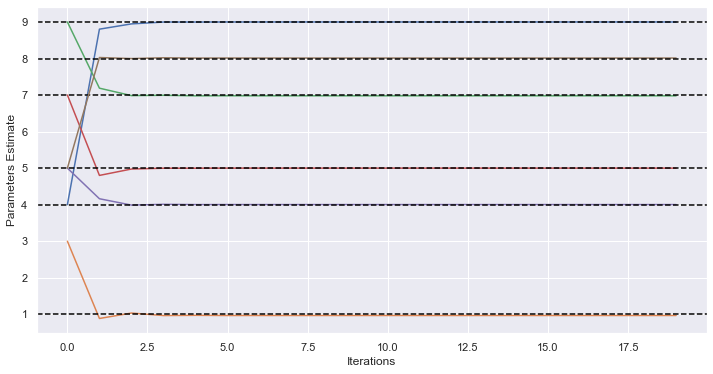

In [53]:
backfit_plot(n=100, p=5, iterations=20);

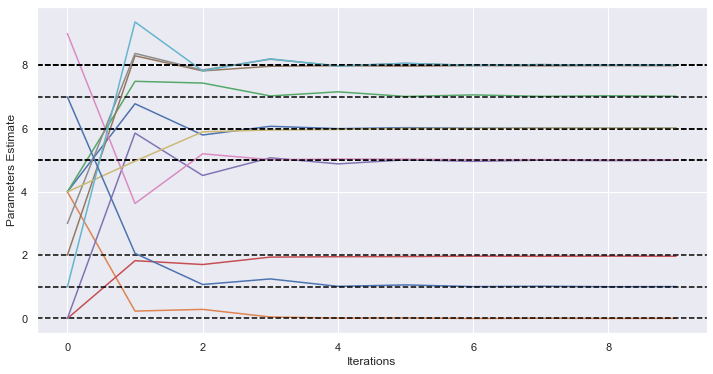

In [54]:
backfit_plot(n=100, p=10, iterations=10);

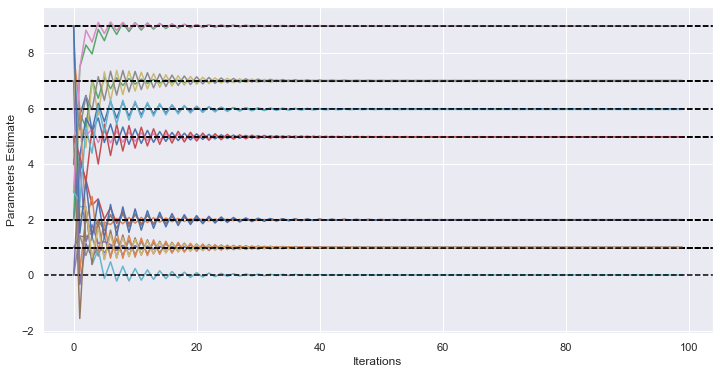

In [55]:
backfit_plot(n=100, p=20, iterations=100);

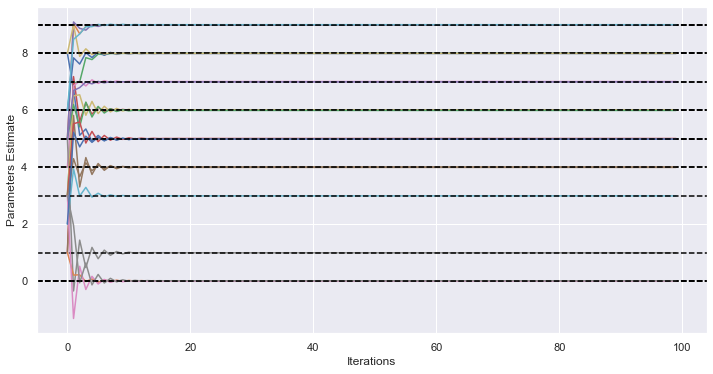

In [56]:
backfit_plot(n=150, p=20, iterations=100);

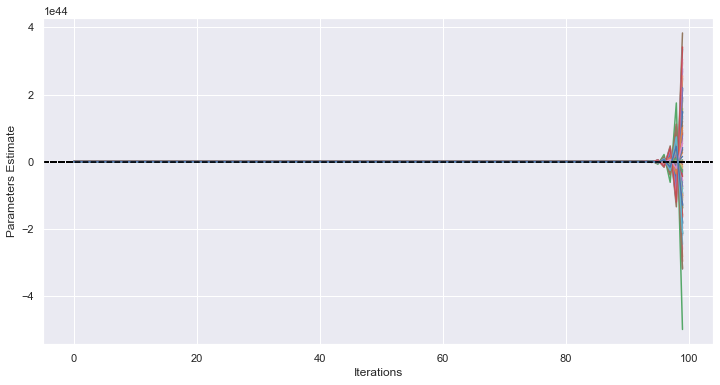

In [57]:
backfit_plot(n=100, p=100, iterations=100);

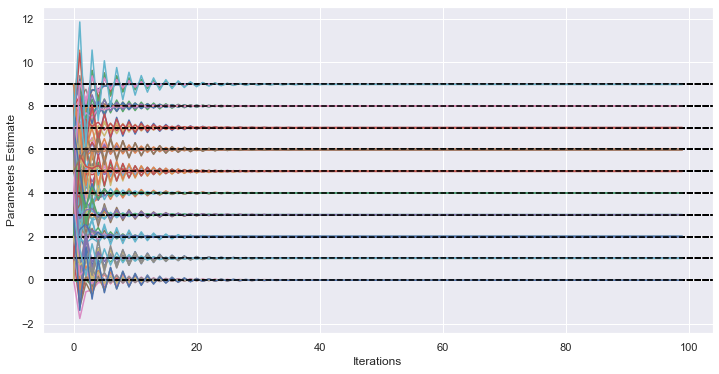

In [58]:
backfit_plot(n=600, p=100, iterations=100);

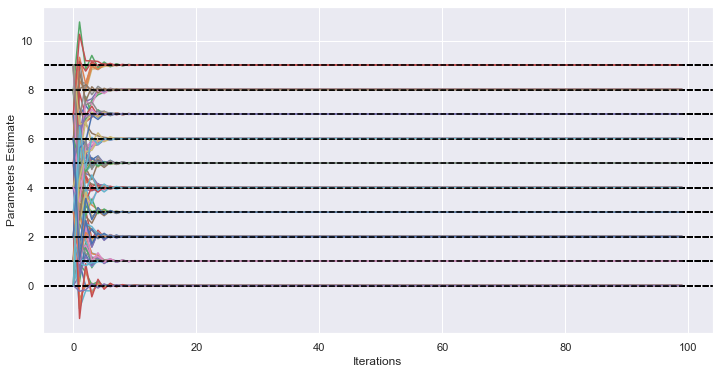

In [59]:
backfit_plot(n=1000, p=100, iterations=100);

In [60]:
interact(backfit_plot, 
         n=widgets.IntSlider(min=100, max=1000, step=20, value=100),
         p=widgets.IntSlider(min=5, max=100, step=5, value=10),
         iterations=widgets.IntSlider(min=10, max=100, step=10, value=10));

interactive(children=(IntSlider(value=100, description='n', max=1000, min=100, step=20), IntSlider(value=10, d…

>**Comment:**
>- Above we've got plots for the coefficient estimates at each iteration using different numbers of observations $n$, and predictors $p$ to simulate a variety of dataset shapes. 
>- This follows by using multiple linear regression backfitting in the simulated data. 
>- On each plot, horizontal `black-dashed lines` show the true coefficient values.

>- We can see that with fixed $n$ (number of observations), by increasing $p$ (number of predictors) the backfitting starts to require more iterations to obtain "good" results.
>- And when the $p$ value reaches approximately $n/5$, convergence starts to be messy and divergent.
>- Then we can say:
>  - Convergence is dependant on the numbers of observations $n$, and predictors $p$.
>  - Convergence is not observed when approximately $p > n/5$. The factor is $p$ must be smaller than $n/5$.
>- This means, for $p = 100$, convergence would start to occur in $n > 500$.

# Done!